# KNN Classifier and Regression 

Using domain knowledge in cars, KNN was used to predict missing car attributes

## Imports

In [1]:
import pandas as pd
import numpy as np
import requests
from bs4 import BeautifulSoup
import re
import time
from tqdm import tqdm
import pickle as pkl
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
from selenium import webdriver
from selenium.webdriver.common.by import By 
from selenium.webdriver.support.ui import WebDriverWait 
from selenium.webdriver.support import expected_conditions as EC 
from selenium.common.exceptions import TimeoutException

In [3]:
root_url ='https://www.carspecs.us'

## Inspecting NaNs and other cleaning steps

In [4]:
df_reg = pkl.load(open('df_pickles/df_reg.p','rb'))

In [5]:
df_reg.isna().sum();

In [6]:
sean = df_reg[df_reg['Engine type']!='Electric']

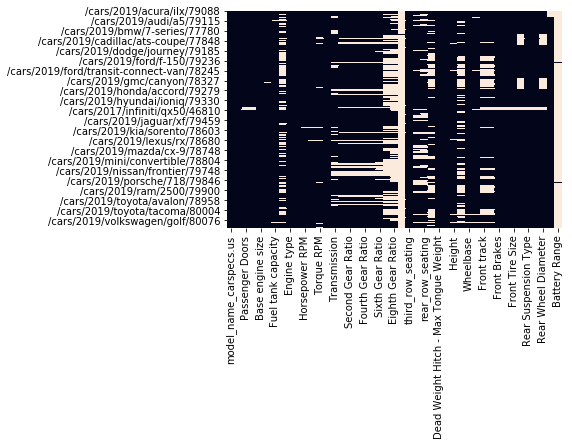

In [7]:
sns.heatmap(sean.isna(), cbar=False)

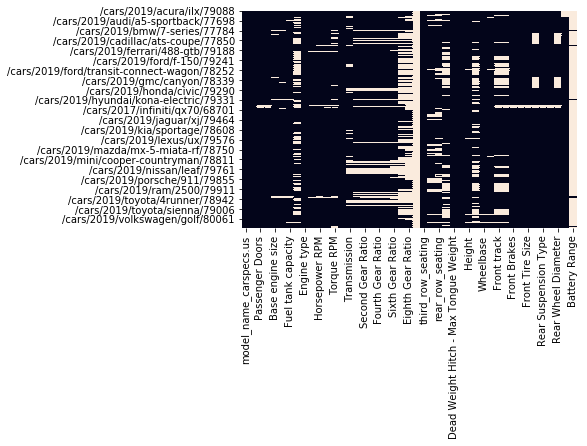

In [8]:
sns.heatmap(df_reg.isna(), cbar=False)

In [9]:
# pkl.dump(df_reg, open('df_pickles/df_reg.p','wb'))

In [10]:
for i in df_reg[(df_reg['Sixth Gear Ratio'] > 0)].index:
    if (type(df_reg.at[i, 'EPA mileage (combined)']) == type(np.nan)):
        df_reg.at[i,'Seventh Gear Ratio'] =0
        df_reg.at[i,'Eighth Gear Ratio'] =0
        df_reg.at[i,'Ninth Gear Ratio'] =0

In [11]:
df_reg['Ninth Gear Ratio'].fillna(value=0,axis=0,inplace=True)

In [12]:
df_reg['Eighth Gear Ratio'].fillna(value=0,axis=0,inplace=True)

In [13]:
df_reg['Seventh Gear Ratio'].fillna(value=0,axis=0,inplace=True)

In [14]:
df_reg[(df_reg['Sixth Gear Ratio'] > 0)].isna().sum();

In [15]:
df_reg;

## Column by column KNN interpolation

### Imports and Models

In [16]:
from collections import defaultdict
from scipy.stats import hmean
from scipy.spatial.distance import cdist
from scipy import stats
import numbers
from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier

In [17]:
neigh_class = KNeighborsClassifier(n_neighbors=50)

In [18]:
neigh_reg = KNeighborsRegressor(n_neighbors=50)

In [19]:
df_reg.columns;

In [20]:
# KNN no additional imposed base predictor
def knn_predictor(df,X,y,model):
    df_no_nan = pd.concat([df[X],df[y]],axis=1).dropna() #drop nans in X and y
    X_ = df_no_nan[X] # seperate X and y after clearing the nans
    y_ = df_no_nan[y]
    print(np.array(y_).reshape(1,-1)[0])
    model.fit(X_, list(np.array(y_).reshape(1,-1)[0])) # fit the data using the appropriate method (classification or regression)
    print(model.fit(X_, list(np.array(y_).reshape(1,-1)[0])))
    y_to_predict = list(df[df[y].isna()].index) # filter y so that it only has nans
    predictions = list(model.predict(df[df[y].isna()][X])) # predict the y values that are nan
    print(len(y_to_predict))
    print(len(predictions))
    for i in range(len(y_to_predict)):
        df.loc[y_to_predict[i], y] = predictions[i] # replace nans in column with predicted value
        print(i, df.loc[y_to_predict[i], y])

### Predicting Continuous Data

#### 'Passenger Doors'

In [21]:
df_reg['Passenger Doors'].value_counts()

4    1837
2     353
3      59
Name: Passenger Doors, dtype: int64

In [22]:
df_reg[df_reg['Passenger Doors'].isna()][['Wheelbase', 'Length','rear_row_seating', 'Passenger Doors']];

In [23]:
df_reg.at['/cars/2017/infiniti/qx30/46804', 'rear_row_seating'] = 73194.550

In [24]:
df_reg.at['/cars/2017/infiniti/qx30/46805', 'rear_row_seating'] = 73194.550

In [25]:
knn_predictor(df_reg,['Wheelbase', 'Length','rear_row_seating'],'Passenger Doors', neigh_class);

[4 4 4 ... 4 4 4]
KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=50, p=2,
                     weights='uniform')
31
31
0 4
1 4
2 4
3 4
4 4
5 4
6 4
7 2
8 2
9 2
10 2
11 2
12 2
13 2
14 2
15 2
16 2
17 4
18 4
19 4
20 4
21 4
22 4
23 4
24 4
25 4
26 4
27 4
28 4
29 4
30 4


#### 'Passenger Capacity'

In [32]:
df_reg[df_reg['Passenger Capacity'].isna()][['Wheelbase', 'Length','rear_row_seating', 
                                             'third_row_seating', 'Passenger Doors', 'Passenger Capacity']]

,Wheelbase,Length,rear_row_seating,third_row_seating,Passenger Doors,Passenger Capacity


In [34]:
knn_predictor(df_reg, ['Wheelbase', 'Length','rear_row_seating', 
                      'Passenger Doors'],'Passenger Capacity',neigh_class)

[5 5 5 ... 7 7 7]
KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=50, p=2,
                     weights='uniform')


ValueError: Found array with 0 sample(s) (shape=(0, 4)) while a minimum of 1 is required.

#### 'Cylinders'

In [38]:
df_reg[(df_reg['Cylinders'].isna()) & (df_reg['Engine type'] == 'Gas')][['Cylinders', 
                                                                         'Fuel tank capacity','Horsepower',
                                                                         'Base engine size','Engine type']]

,Cylinders,Fuel tank capacity,Horsepower,Base engine size,Engine type


In [39]:
# same function as before but with additional condtion to exclude nans when multiple features are used
def knn_predictor2(df,X,y,model,condtion):
    df_no_nan = pd.concat([df[X],df[y]],axis=1).dropna()
    X_ = df_no_nan[X]
    y_ = df_no_nan[y]
    print(np.array(y_).reshape(1,-1)[0])
    model.fit(X_, list(np.array(y_).reshape(1,-1)[0]))
    print(model.fit(X_, list(np.array(y_).reshape(1,-1)[0])))
    y_to_predict = list(df[(df[y].isna())&(condtion)].index)
    predictions = list(model.predict(df[df[y].isna()&(condtion)][X]))
    print(len(y_to_predict))
    print(len(predictions))
    for i in range(len(y_to_predict)):
        df.loc[y_to_predict[i], y] = predictions[i]
        print(i, df.loc[y_to_predict[i], y])

In [40]:
knn_predictor2(df_reg,['Base engine size', 'Horsepower', 'Fuel tank capacity'],'Cylinders', neigh_class, df_reg['Engine type'] == 'Gas')

[4 4 4 ... 4 4 4]
KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=50, p=2,
                     weights='uniform')


ValueError: Found array with 0 sample(s) (shape=(0, 3)) while a minimum of 1 is required.

In [41]:
df_reg.loc['/cars/2017/infiniti/q50/47429','Cylinders']

4

#### Base engine size

In [42]:
df_reg[(df_reg['Base engine size'].isna()) & (df_reg['Engine type'] == 'Gas')][['Cylinders', 'Fuel tank capacity','Base engine size','Engine type']]

,Cylinders,Fuel tank capacity,Base engine size,Engine type
/cars/2019/buick/encore/77818,4,14,NaN,Gas
/cars/2019/buick/encore/77819,4,14,NaN,Gas
/cars/2019/buick/encore/77820,4,14,NaN,Gas
/cars/2019/buick/encore/77824,4,14,NaN,Gas
/cars/2019/buick/encore/77821,4,14,NaN,Gas
/cars/2019/buick/encore/77822,4,14,NaN,Gas
/cars/2019/buick/encore/77823,4,14,NaN,Gas
/cars/2019/gmc/acadia/78309,4,22,NaN,Gas
/cars/2019/gmc/acadia/78314,4,19,NaN,Gas


In [43]:
knn_predictor2(df_reg,['Cylinders', 'Horsepower'],'Base engine size', neigh_reg, df_reg['Engine type'] == 'Gas')

[2.4 2.4 2.4 ... 2.0 2.0 2.0]
KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
                    metric_params=None, n_jobs=None, n_neighbors=50, p=2,
                    weights='uniform')
9
9
0 1.694
1 1.694
2 1.694
3 1.694
4 1.694
5 1.694
6 1.694
7 1.9879999999999998
8 1.9879999999999998


#### 'Fuel tank capacity'

In [44]:
df_reg[(df_reg['Fuel tank capacity'].isna()) & (df_reg['Engine type'] == 'Gas')][['Cylinders', 'Fuel tank capacity','Base engine size','Engine type']]

,Cylinders,Fuel tank capacity,Base engine size,Engine type
/cars/2019/audi/a6/77707,6,NaN,3,Gas
/cars/2019/audi/a6/77708,6,NaN,3,Gas
/cars/2019/audi/a6/77709,6,NaN,3,Gas
/cars/2019/audi/a7/77711,6,NaN,3,Gas
/cars/2019/audi/a7/77710,6,NaN,3,Gas
/cars/2019/audi/a7/77712,6,NaN,3,Gas
/cars/2019/audi/q8/77724,6,NaN,3,Gas
/cars/2019/audi/q8/77722,6,NaN,3,Gas
/cars/2019/audi/q8/77723,6,NaN,3,Gas
/cars/2019/rolls-royce/cullinan/79914,12,NaN,6.8,Gas


In [45]:
knn_predictor2(df_reg,['Cylinders', 'Horsepower'],'Fuel tank capacity', neigh_reg, df_reg['Engine type'] == 'Gas')

[13.2 13.2 13.2 ... 13.2 13.2 13.2]
KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
                    metric_params=None, n_jobs=None, n_neighbors=50, p=2,
                    weights='uniform')
16
16
0 19.046
1 19.046
2 19.046
3 19.046
4 19.046
5 19.046
6 19.046
7 19.046
8 19.046
9 20.965999999999998
10 16.605999999999998
11 16.605999999999998
12 16.605999999999998
13 16.832
14 16.832
15 16.832


In [46]:
df_reg.isna().sum();

#### 'Torque', 'Torque RPM', 'Horsepower', 'Horsepower RPM'

In [48]:
df_reg[(df_reg['Horsepower'].isna()) & (df_reg['Engine type'] == 'Gas')][['Torque', 'Torque RPM', 'Horsepower', 
                                                                      'Horsepower RPM','Engine type', 'Cylinders', 'Drive type',
                                                                         'Fuel tank capacity']];

In [49]:
df_reg.drop(['Torque RPM', 'Horsepower RPM'],1,inplace=True)

In [50]:
df_reg.loc['/cars/2019/cadillac/ct6/77858', 'Horsepower'] = 237
df_reg.loc['/cars/2019/cadillac/ct6/77858', 'Torque'] = 258

In [51]:
df_reg.loc['/cars/2019/cadillac/ct6/77853', 'Horsepower'] = 237 
df_reg.loc['/cars/2019/cadillac/ct6/77853', 'Torque'] = 258

In [52]:
df_reg.loc['/cars/2019/cadillac/ct6/77854', 'Horsepower'] = 335
df_reg.loc['/cars/2019/cadillac/ct6/77854', 'Torque'] = 284

In [53]:
df_reg.loc['/cars/2019/cadillac/ct6/77856', 'Horsepower'] = 404 
df_reg.loc['/cars/2019/cadillac/ct6/77856', 'Torque'] = 400

In [54]:
df_reg.loc['/cars/2019/cadillac/ct6/77857', 'Horsepower'] = 335
df_reg.loc['/cars/2019/cadillac/ct6/77857', 'Torque'] = 284

In [56]:
df_reg[(df_reg['Horsepower'].isna()) & (df_reg['Engine type'] == 'Gas')][['Torque', 'Horsepower','Engine type', 'Cylinders', 'Drive type',
                                                                         'Fuel tank capacity']];

In [57]:
knn_predictor2(df_reg,['Cylinders','Fuel tank capacity'],'Torque', neigh_reg, df_reg['Engine type'] == 'Gas')

[180.0 180.0 180.0 ... 472.0 472.0 472.0]
KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
                    metric_params=None, n_jobs=None, n_neighbors=50, p=2,
                    weights='uniform')
17
17
0 335.52
1 335.52
2 335.52
3 175.18
4 175.18
5 199.04
6 199.04
7 199.04
8 175.18
9 175.8
10 175.8
11 175.8
12 175.8
13 175.8
14 137.94
15 137.94
16 137.94


In [59]:
knn_predictor2(df_reg,['Cylinders','Fuel tank capacity'],'Horsepower', neigh_reg, df_reg['Engine type'] == 'Gas')

[201.0 201.0 201.0 ... 400.0 400.0 400.0]
KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
                    metric_params=None, n_jobs=None, n_neighbors=50, p=2,
                    weights='uniform')
6
6
0 199.32
1 199.32
2 199.92
3 199.92
4 199.92
5 199.32


#### first_row_seating, rear_row_seating, 'Width'

In [61]:
df_reg.isna().sum()[21:];

In [62]:
df_reg.drop(['Length', 'Front track', 'Rear track'],1, inplace=True)

In [63]:
df_reg[(df_reg['first_row_seating'].isna()) & (df_reg['Wheelbase'].notna()) & (df_reg['Width'].notna())][['first_row_seating', 'rear_row_seating', 'Curb weight', 'Height',
                                                'Wheelbase', 'Width']].head()

,first_row_seating,rear_row_seating,Curb weight,Height,Wheelbase,Width
/cars/2018/alfa-romeo/stelvio/75376,NaN,NaN,4044,66,111,74.9
/cars/2018/alfa-romeo/stelvio/75377,NaN,NaN,4044,66,111,74.9
/cars/2018/alfa-romeo/stelvio/75378,NaN,NaN,4044,66,111,74.9
/cars/2018/alfa-romeo/stelvio/75379,NaN,NaN,4044,66,111,74.9
/cars/2019/aston-martin/db11/79095,NaN,NaN,4134,50.8,110.4,76.8


In [64]:
# two condtions
def knn_predictor3(df,X,y,model,condition1,condition2):
    df_no_nan = pd.concat([df[X],df[y]],axis=1).dropna()
    X_ = df_no_nan[X]
    y_ = df_no_nan[y]
    print(np.array(y_).reshape(1,-1)[0])
    model.fit(X_, list(np.array(y_).reshape(1,-1)[0]))
    print(model.fit(X_, list(np.array(y_).reshape(1,-1)[0])))
    y_to_predict = list(df[(df[y].isna())& (condition1) & (condition2)].index)
    predictions = list(model.predict(df[df[y].isna()& (condition1) & (condition2)][X]))
    print(len(y_to_predict))
    print(len(predictions))
    for i in range(len(y_to_predict)):
        df.loc[y_to_predict[i], y] = predictions[i]
        print(i, df.loc[y_to_predict[i], y])

In [65]:
knn_predictor3(df_reg,['Width','Wheelbase','Base engine size'],'first_row_seating', neigh_reg, df_reg['Wheelbase'].notna(), df_reg['Width'].notna())

[89371.44  89371.44  89371.44  ... 91801.277 91801.277 91801.277]
KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
                    metric_params=None, n_jobs=None, n_neighbors=50, p=2,
                    weights='uniform')
224
224
0 95282.09298
1 95282.09298
2 95282.09298
3 95282.09298
4 98427.06558
5 97761.13248
6 98364.70332
7 98364.70332
8 92913.78294000002
9 93508.56728
10 93508.56728
11 93508.56728
12 94981.11382
13 94981.11382
14 94981.11382
15 104002.17977999998
16 102003.11605999999
17 109276.1657
18 102003.11605999999
19 109276.1657
20 98428.00588
21 98428.00588
22 107526.65690000002
23 102056.97884
24 102056.97884
25 90596.20671999999
26 99393.55885999998
27 99393.55885999998
28 99393.55885999998
29 99393.55885999998
30 99393.55885999998
31 99393.55885999998
32 99393.55885999998
33 99393.55885999998
34 99393.55885999998
35 99393.55885999998
36 99393.55885999998
37 99393.55885999998
38 99393.55885999998
39 99393.55885999998
40 99393.55885999998
41 9

In [66]:
knn_predictor3(df_reg,['Width','Wheelbase','Base engine size'],'rear_row_seating', neigh_reg, df_reg['Wheelbase'].notna(), df_reg['Width'].notna())

[65424.16 65424.16 65424.16 ... 80484.25 80484.25 80484.25]
KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
                    metric_params=None, n_jobs=None, n_neighbors=50, p=2,
                    weights='uniform')
415
415
0 78445.4156
1 65319.718964999985
2 65319.718964999985
3 79275.68677999999
4 79275.68677999999
5 79275.68677999999
6 79275.68677999999
7 79275.68677999999
8 79275.68677999999
9 85428.54276000001
10 85428.54276000001
11 85428.54276000001
12 85428.54276000001
13 83858.99516
14 83938.22764
15 85157.23157999999
16 85157.23157999999
17 77639.56468000001
18 77639.56468000001
19 73745.57303999999
20 72087.92858
21 72087.92858
22 72087.92858
23 77725.10906
24 77725.10906
25 77725.10906
26 75925.54920000001
27 75925.54920000001
28 75925.54920000001
29 81751.81176000001
30 81751.81176000001
31 81751.81176000001
32 91895.25448799999
33 70907.85656
34 70487.82414000001
35 70487.82414000001
36 70487.82414000001
37 71233.63597999999
38 71233.635979999

In [67]:
knn_predictor3(df_reg,['Wheelbase','Height'],'Width', neigh_reg, df_reg['Wheelbase'].notna(), df_reg['Height'].notna())

[70.6 70.6 70.6 ... 79.1 79.1 79.1]
KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
                    metric_params=None, n_jobs=None, n_neighbors=50, p=2,
                    weights='uniform')
19
19
0 70.296
1 70.296
2 70.296
3 70.296
4 70.296
5 70.296
6 72.914
7 70.32599999999998
8 70.55200000000002
9 75.674
10 75.674
11 75.674
12 75.674
13 75.674
14 68.69999999999999
15 68.7
16 68.69999999999999
17 68.7
18 68.7


In [68]:
df_reg.isna().sum()

model_name_carspecs.us                       0
price                                        0
Passenger Doors                              0
Passenger Capacity                           0
Base engine size                            57
Cylinders                                   57
Fuel tank capacity                          52
EPA mileage (combined)                     895
Engine type                                  2
Horsepower                                  21
Torque                                      19
Drive type                                   0
Transmission                               323
First Gear Ratio                           275
Second Gear Ratio                          297
Third Gear Ratio                           300
Fourth Gear Ratio                          300
Fifth Gear Ratio                           306
Sixth Gear Ratio                           359
Seventh Gear Ratio                           0
Eighth Gear Ratio                            0
Ninth Gear Ra

In [69]:
df_reg[(df_reg['Front Brakes'].isna())][['Front Suspension Type', 'Rear Suspension Type', 'Rear Tire Size', 'Front Brakes']]

,Front Suspension Type,Rear Suspension Type,Rear Tire Size,Front Brakes
/cars/2017/infiniti/q50/47438,NaN,NaN,NaN,NaN
/cars/2017/infiniti/q50/47436,NaN,NaN,NaN,NaN
/cars/2017/infiniti/q50/47440,NaN,NaN,NaN,NaN
/cars/2017/infiniti/q50/47434,NaN,NaN,NaN,NaN
/cars/2017/infiniti/q50/47430,NaN,NaN,NaN,NaN
/cars/2017/infiniti/q50/47441,NaN,NaN,NaN,NaN
/cars/2017/infiniti/q50/47442,NaN,NaN,NaN,NaN
/cars/2017/infiniti/q60-coupe/45249,NaN,NaN,NaN,NaN
/cars/2017/infiniti/q60-coupe/47443,NaN,NaN,NaN,NaN
/cars/2017/infiniti/q60-coupe/47444,NaN,NaN,NaN,NaN


#### Gears

In [70]:
# four condtions
def knn_predictor4(df,X,y,model):
    df_no_nan = pd.concat([df[X],df[y]],axis=1).dropna()
    X_ = df_no_nan[X]
    y_ = df_no_nan[y]
    print(np.array(y_).reshape(1,-1)[0])
    model.fit(X_, list(np.array(y_).reshape(1,-1)[0]))
    print(model.fit(X_, list(np.array(y_).reshape(1,-1)[0])))
    y_to_predict = list(df[ (df[y].isna()) & 
                           (df['Base engine size'].notna()) & 
                           (df['Horsepower'].notna()) & 
                           (df['Torque'].notna())& 
                           (df['Engine type']!='Electric')].index)
    predictions = list(model.predict(df[ (df[y].isna()) & 
                                        (df['Base engine size'].notna()) & 
                                        (df['Horsepower'].notna()) & 
                                        (df['Torque'].notna()) & 
                                        (df['Engine type']!='Electric')][X]))
    print(len(y_to_predict))
    print(len(predictions))
    for i in range(len(y_to_predict)):
        df.loc[y_to_predict[i], y] = predictions[i]
        print(i, df.loc[y_to_predict[i], y])

In [73]:
df_reg[(df_reg['First Gear Ratio'].isna())][['First Gear Ratio', 'Second Gear Ratio',
                                   'Third Gear Ratio', 'Fourth Gear Ratio','Fifth Gear Ratio', 'Sixth Gear Ratio']]

,First Gear Ratio,Second Gear Ratio,Third Gear Ratio,Fourth Gear Ratio,Fifth Gear Ratio,Sixth Gear Ratio
/cars/2019/bmw/i3/79144,NaN,NaN,NaN,NaN,NaN,NaN
/cars/2019/bmw/i3/79143,NaN,NaN,NaN,NaN,NaN,NaN
/cars/2019/bmw/i3/79146,NaN,NaN,NaN,NaN,NaN,NaN
/cars/2019/bmw/i3/79145,NaN,NaN,NaN,NaN,NaN,NaN
/cars/2019/buick/regal-sportback/77834,NaN,NaN,NaN,NaN,NaN,NaN
/cars/2019/buick/regal-sportback/77835,NaN,NaN,NaN,NaN,NaN,NaN
/cars/2019/buick/regal-sportback/77836,NaN,NaN,NaN,NaN,NaN,NaN
/cars/2019/buick/regal-sportback/77837,NaN,NaN,NaN,NaN,NaN,NaN
/cars/2019/buick/regal-sportback/77838,NaN,NaN,NaN,NaN,NaN,NaN
/cars/2019/buick/regal-sportback/77839,NaN,NaN,NaN,NaN,NaN,NaN


In [74]:
knn_predictor4(df_reg,['Torque','Horsepower','Base engine size'],'First Gear Ratio', neigh_reg);

[3.08 3.08 3.08 ... 5.25 5.25 5.25]
KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
                    metric_params=None, n_jobs=None, n_neighbors=50, p=2,
                    weights='uniform')
241
241
0 4.8718
1 4.4232000000000005
2 4.8718
3 4.8718
4 4.4132
5 4.8718
6 4.4232000000000005
7 4.8718
8 4.4232000000000005
9 4.4232000000000005
10 4.4232000000000005
11 4.4376
12 4.4376
13 4.7421999999999995
14 4.9216
15 4.7829999999999995
16 4.7422
17 4.8404
18 4.8404
19 4.8404
20 4.8404
21 4.8404
22 4.8404
23 4.8404
24 4.8404
25 4.4376
26 4.4376
27 4.4376
28 4.4376
29 4.4376
30 4.4376
31 4.1486
32 4.1486
33 4.2232
34 4.2232
35 4.2232
36 4.2232
37 4.2232
38 4.3296
39 3.9200000000000004
40 4.3296
41 3.9200000000000004
42 4.3296
43 3.9200000000000004
44 4.255399999999999
45 4.255399999999999
46 4.255399999999999
47 4.300799999999999
48 4.300799999999999
49 4.3914
50 4.255399999999999
51 4.356
52 4.356
53 4.356
54 4.356
55 4.467600000000001
56 4.467600000000001
57 4.35

In [75]:
knn_predictor4(df_reg,['Torque','Horsepower','Base engine size', 'First Gear Ratio' ],'Second Gear Ratio', neigh_reg);

[2.18 2.18 2.18 ... 3.03 3.03 3.03]
KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
                    metric_params=None, n_jobs=None, n_neighbors=50, p=2,
                    weights='uniform')
242
242
0 3.0041999999999995
1 2.8028000000000004
2 3.0041999999999995
3 3.0041999999999995
4 2.758
5 3.0041999999999995
6 2.8028000000000004
7 3.0041999999999995
8 2.8028000000000004
9 2.8028000000000004
10 2.8028000000000004
11 2.6437999999999993
12 2.6437999999999993
13 2.9586
14 3.1296000000000004
15 3.0983999999999994
16 2.9586
17 3.0529999999999995
18 3.0529999999999995
19 3.0529999999999995
20 3.0529999999999995
21 3.0529999999999995
22 3.0529999999999995
23 3.0529999999999995
24 3.0529999999999995
25 2.6437999999999993
26 2.6437999999999993
27 2.6437999999999993
28 2.6437999999999993
29 2.6437999999999993
30 2.6437999999999993
31 2.696
32 2.696
33 2.6706
34 2.6706
35 2.6706
36 2.6706
37 2.6706
38 2.6289999999999996
39 2.3794000000000004
40 2.6289999999999996
41

In [76]:
knn_predictor4(df_reg,['Torque','Horsepower','Base engine size', 'Second Gear Ratio', 'First Gear Ratio'],'Third Gear Ratio', neigh_reg)

[1.61 1.61 1.61 ... 1.95 1.95 1.95]
KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
                    metric_params=None, n_jobs=None, n_neighbors=50, p=2,
                    weights='uniform')
245
245
0 1.97
1 1.8285999999999998
2 1.97
3 1.97
4 1.8556
5 1.97
6 1.8285999999999998
7 1.97
8 1.8285999999999998
9 1.8285999999999998
10 1.8285999999999998
11 1.7456
12 1.7456
13 1.9477999999999998
14 2.1012
15 2.0768
16 1.9477999999999998
17 2.0852
18 2.0852
19 2.0852
20 2.0852
21 2.0852
22 2.0852
23 2.0852
24 2.0852
25 1.7456
26 1.7456
27 1.7456
28 1.7456
29 1.7456
30 1.7456
31 1.9710000000000003
32 1.9710000000000003
33 2.0122
34 2.0122
35 2.0122
36 2.0122
37 2.0122
38 1.8032
39 1.6638
40 1.8032
41 1.6638
42 1.8032
43 1.6638
44 1.7042000000000002
45 1.7042000000000002
46 1.7042000000000002
47 2.0178
48 2.0178
49 1.7296
50 1.7042000000000002
51 1.9791999999999998
52 1.7739999999999998
53 1.7739999999999998
54 1.7739999999999998
55 1.7739999999999998
56 1.8082
57 1.

In [77]:
knn_predictor4(df_reg,['Torque','Horsepower','Base engine size', 'Third Gear Ratio'],'Fourth Gear Ratio', neigh_reg)

[1.22 1.22 1.22 ... 1.46 1.46 1.46]
KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
                    metric_params=None, n_jobs=None, n_neighbors=50, p=2,
                    weights='uniform')
245
245
0 1.5096
1 1.3499999999999996
2 1.5096
3 1.5096
4 1.4408000000000003
5 1.5096
6 1.3499999999999996
7 1.5096
8 1.3499999999999996
9 1.3499999999999996
10 1.3499999999999996
11 1.2515999999999998
12 1.2515999999999998
13 1.4421999999999997
14 1.6424
15 1.5851999999999997
16 1.4421999999999997
17 1.6484
18 1.6484
19 1.6484
20 1.6484
21 1.6484
22 1.6484
23 1.6484
24 1.6484
25 1.2515999999999998
26 1.2515999999999998
27 1.2515999999999998
28 1.2515999999999998
29 1.2515999999999998
30 1.2515999999999998
31 1.3082
32 1.3082
33 1.4262000000000001
34 1.4262000000000001
35 1.4262000000000001
36 1.4262000000000001
37 1.4262000000000001
38 1.2935999999999999
39 1.2342
40 1.2935999999999999
41 1.2342
42 1.2935999999999999
43 1.2342
44 1.2584
45 1.2584
46 1.2584
47 1.424799

In [78]:
knn_predictor4(df_reg,['Torque','Horsepower','Base engine size', 'Third Gear Ratio'],'Fifth Gear Ratio', neigh_reg)

[0.96 0.96 0.96 ... 1.22 1.22 1.22]
KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
                    metric_params=None, n_jobs=None, n_neighbors=50, p=2,
                    weights='uniform')
251
251
0 1.1912
1 1.0024000000000002
2 1.1912
3 1.1912
4 1.1118
5 1.1912
6 1.0024000000000002
7 1.1912
8 1.0024000000000002
9 1.0024000000000002
10 1.0024000000000002
11 1.0
12 1.0
13 1.1044
14 1.2102000000000002
15 1.2332
16 1.1043999999999998
17 1.2970000000000002
18 1.2970000000000002
19 1.2970000000000002
20 1.2970000000000002
21 1.2970000000000002
22 1.2970000000000002
23 1.2970000000000002
24 1.2970000000000002
25 1.0
26 1.0
27 1.0
28 1.0
29 1.0
30 1.0
31 1.0072
32 1.0072
33 0.9660000000000001
34 0.9660000000000001
35 0.9660000000000001
36 1.075
37 1.075
38 1.075
39 1.075
40 1.075
41 0.9797999999999999
42 0.9258
43 0.9797999999999999
44 0.9258
45 0.9797999999999999
46 0.9258
47 0.9612
48 0.9612
49 0.9612
50 1.0528000000000002
51 1.0528000000000002
52 0.9708
53 0

In [79]:
knn_predictor4(df_reg,['Torque','Horsepower','Base engine size', 'Fifth Gear Ratio'],'Sixth Gear Ratio', neigh_reg)

[0.74 0.74 0.74 ... 1.0 1.0 1.0]
KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
                    metric_params=None, n_jobs=None, n_neighbors=50, p=2,
                    weights='uniform')
304
304
0 0.9483999999999999
1 0.8153999999999999
2 0.9483999999999999
3 0.9483999999999999
4 0.8974000000000001
5 0.9483999999999999
6 0.8153999999999999
7 0.9483999999999999
8 0.8153999999999999
9 0.8153999999999999
10 0.8153999999999999
11 0.8568000000000001
12 0.8568000000000001
13 0.9078
14 0.9584000000000001
15 1.0166000000000002
16 0.9078
17 1.0368
18 1.0368
19 1.0368
20 1.0368
21 1.0368
22 1.0368
23 1.0368
24 1.0368
25 0.8568000000000001
26 0.8568000000000001
27 0.8568000000000001
28 0.8568000000000001
29 0.8568000000000001
30 0.8568000000000001
31 0.8615999999999999
32 0.8615999999999999
33 0.7588000000000001
34 0.7588000000000001
35 0.7588000000000001
36 0.76
37 0.76
38 0.7151999999999998
39 0.7151999999999998
40 0.7151999999999998
41 0.7151999999999998
42 0.715

In [80]:
df_reg.drop(['Seventh Gear Ratio', 'Eighth Gear Ratio', 'Ninth Gear Ratio', 'Front Brakes'],1,inplace=True)

### Predicting categorical data

In [69]:
df_reg

,model_name_carspecs.us,price,Passenger Doors,Passenger Capacity,Base engine size,Cylinders,Fuel tank capacity,EPA mileage (combined),Engine type,Horsepower,...,Wheelbase,Width,Front Suspension Type,Front Tire Size,Front Wheel Diameter,Rear Suspension Type,Rear Tire Size,Rear Wheel Diameter,extra_options,Battery Range
/cars/2019/acura/ilx/79088,2019 Acura ILX Sedan,25900,4,5,2.4,4,13.2,28,Gas,201,...,105.1,70.6,Independent MacPherson Strut,P215/45VR17,17,Independent Multi-Link,P215/45VR17,17,NaN,NaN
/cars/2019/acura/ilx/79090,2019 Acura ILX Sedan w/Premium Pkg,27650,4,5,2.4,4,13.2,28,Gas,201,...,105.1,70.6,Independent MacPherson Strut,P215/45VR17,17,Independent Multi-Link,P215/45VR17,17,NaN,NaN
/cars/2019/acura/ilx/79089,2019 Acura ILX Sedan w/Premium/A-Spec Pkg,29650,4,5,2.4,4,13.2,28,Gas,201,...,105.1,70.6,Independent MacPherson Strut,P225/40VR18,18,Independent Multi-Link,P225/40VR18,18,NaN,NaN
/cars/2019/acura/ilx/79092,2019 Acura ILX Sedan w/Technology Pkg,29550,4,5,2.4,4,13.2,28,Gas,201,...,105.1,70.6,Independent MacPherson Strut,P215/45VR17,17,Independent Multi-Link,P215/45VR17,17,NaN,NaN
/cars/2019/acura/ilx/79091,2019 Acura ILX Sedan w/Technology/A-Spec Pkg,31550,4,5,2.4,4,13.2,28,Gas,201,...,105.1,70.6,Independent MacPherson Strut,P225/40VR18,18,Independent Multi-Link,P225/40VR18,18,NaN,NaN
/cars/2019/acura/mdx/77624,2019 Acura MDX FWD,44300,4,7,3.5,6,19.5,23,Gas,290,...,111,77.7,Independent MacPherson Strut,P245/60HR18,18,Independent Multi-Link,P245/60HR18,18,NaN,NaN
/cars/2019/acura/mdx/77621,2019 Acura MDX FWD w/Advance Pkg,56050,4,6,3.5,6,19.5,23,Gas,290,...,111,77.7,Independent MacPherson Strut,P265/45HR20,20,Independent Multi-Link,P265/45HR20,20,NaN,NaN
/cars/2019/acura/mdx/77620,2019 Acura MDX FWD w/Advance/Entertainment Pkg,58050,4,7,3.5,6,19.5,23,Gas,290,...,111,77.7,Independent MacPherson Strut,P265/45HR20,20,Independent Multi-Link,P265/45HR20,20,NaN,NaN
/cars/2019/acura/mdx/77623,2019 Acura MDX FWD w/Technology Pkg,49300,4,7,3.5,6,19.5,23,Gas,290,...,111,77.7,Independent MacPherson Strut,P245/50HR20,20,Independent Multi-Link,P245/50HR20,20,NaN,NaN
/cars/2019/acura/mdx/77622,2019 Acura MDX FWD w/Technology/Entertainment ...,51300,4,6,3.5,6,19.5,23,Gas,290,...,111,77.7,Independent MacPherson Strut,P245/50HR20,20,Independent Multi-Link,P245/50HR20,20,NaN,NaN


In [70]:
df_reg.iloc[:,30:].head()

,Front Wheel Diameter,Rear Suspension Type,Rear Tire Size,Rear Wheel Diameter,extra_options,Battery Range
/cars/2019/acura/ilx/79088,17,Independent Multi-Link,P215/45VR17,17,NaN,NaN
/cars/2019/acura/ilx/79090,17,Independent Multi-Link,P215/45VR17,17,NaN,NaN
/cars/2019/acura/ilx/79089,18,Independent Multi-Link,P225/40VR18,18,NaN,NaN
/cars/2019/acura/ilx/79092,17,Independent Multi-Link,P215/45VR17,17,NaN,NaN
/cars/2019/acura/ilx/79091,18,Independent Multi-Link,P225/40VR18,18,NaN,NaN


**Creating 'brand', 'model', 'trim' out of the 'model_name_carspecs.us' column**

In [71]:
for i,r in df_reg['model_name_carspecs.us'].items():
    df_reg.at[i, 'brand'] = ''.join(df_reg.loc[i, 'model_name_carspecs.us'].split(' ')[1]).strip()
    df_reg.at[i, 'model'] = ''.join(df_reg.loc[i, 'model_name_carspecs.us'].split(' ')[2]).strip()
    df_reg.at[i, 'trim'] = ' '.join(df_reg.loc[i, 'model_name_carspecs.us'].split(' ')[3:]).strip()
df_reg.drop(['model_name_carspecs.us'],1,inplace=True)

In [74]:
df_reg[df_reg['price'] == 'price not given']

,price,Passenger Doors,Passenger Capacity,Base engine size,Cylinders,Fuel tank capacity,EPA mileage (combined),Engine type,Horsepower,Torque,...,Front Tire Size,Front Wheel Diameter,Rear Suspension Type,Rear Tire Size,Rear Wheel Diameter,extra_options,Battery Range,brand,model,trim
/cars/2019/audi/a3-cabriolet/77677,price not given,2,4,2,4,13.2,NaN,Gas,186,221,...,P225/45HR17,17,Independent Multi-Link,P225/45HR17,17,"[ABS And Driveline Traction Control, Airbag Oc...",NaN,Audi,A3,Cabriolet 2.0 TFSI Premium FWD
/cars/2019/audi/a3-cabriolet/77678,price not given,2,4,2,4,13.2,NaN,Gas,186,221,...,P225/40HR18,17,Independent Multi-Link,P225/40HR18,17,"[ABS And Driveline Traction Control, Airbag Oc...",NaN,Audi,A3,Cabriolet 2.0 TFSI Premium Plus FWD
/cars/2019/audi/a3-cabriolet/77679,price not given,2,4,2,4,14.5,NaN,Gas,220,258,...,P225/40HR18,17,Independent Multi-Link,P225/40HR18,17,"[ABS And Driveline Traction Control, Airbag Oc...",NaN,Audi,A3,Cabriolet 2.0 TFSI Premium Plus quattro AWD
/cars/2019/audi/a3-cabriolet/77680,price not given,2,4,2,4,14.5,NaN,Gas,220,258,...,P225/45HR17,17,Independent Multi-Link,P225/45HR17,17,"[ABS And Driveline Traction Control, Airbag Oc...",NaN,Audi,A3,Cabriolet 2.0 TFSI Premium quattro AWD
/cars/2019/audi/a3-cabriolet/77681,price not given,2,4,2,4,13.2,NaN,Gas,186,221,...,P225/40HR18,18,Independent Multi-Link,P225/40HR18,18,"[ABS And Driveline Traction Control, Airbag Oc...",NaN,Audi,A3,Cabriolet 2.0 TFSI Prestige FWD
/cars/2019/audi/a3-cabriolet/77682,price not given,2,4,2,4,14.5,NaN,Gas,220,258,...,P225/40HR18,18,Independent Multi-Link,P225/40HR18,18,"[ABS And Driveline Traction Control, Airbag Oc...",NaN,Audi,A3,Cabriolet 2.0 TFSI Prestige quattro AWD
/cars/2019/audi/a3-sedan/77683,price not given,4,5,2,4,13.2,NaN,Gas,186,221,...,P225/45HR17,17,Independent Multi-Link,P225/45HR17,17,"[ABS And Driveline Traction Control, Airbag Oc...",NaN,Audi,A3,Sedan 2.0 TFSI Premium FWD
/cars/2019/audi/a3-sedan/77684,price not given,4,5,2,4,13.2,NaN,Gas,186,221,...,P225/40HR18,17,Independent Multi-Link,P225/40HR18,17,"[ABS And Driveline Traction Control, Airbag Oc...",NaN,Audi,A3,Sedan 2.0 TFSI Premium Plus FWD
/cars/2019/audi/a3-sedan/77685,price not given,4,5,2,4,14.5,NaN,Gas,220,258,...,P225/40HR18,17,Independent Multi-Link,P225/40HR18,17,"[ABS And Driveline Traction Control, Airbag Oc...",NaN,Audi,A3,Sedan 2.0 TFSI Premium Plus quattro AWD
/cars/2019/audi/a3-sedan/77686,price not given,4,5,2,4,14.5,NaN,Gas,220,258,...,P225/45HR17,17,Independent Multi-Link,P225/45HR17,17,"[ABS And Driveline Traction Control, Airbag Oc...",NaN,Audi,A3,Sedan 2.0 TFSI Premium quattro AWD


In [72]:
# pkl.dump(df_reg, open('df_pickles/df_reg_1.p','wb'))

**Encoding categorical features with LabelEncoder()**

In [72]:
df_encoded = df_reg.copy()

In [73]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()

In [74]:
# encodes rows and places them directly into the dataframe
def encode_replacer(df, y_encoded, y):
    counter = 0
    for i,r in df[df[y].notna()][y].items():
        df.at[i, y] = y_encoded[counter]
        counter+=1

In [75]:
brand_encoded = le.fit_transform(df_reg[df_reg['brand'].notna()]['brand'])
encode_replacer(df_encoded, brand_encoded, 'brand')

In [77]:
model_encoded = le.fit_transform(df_reg[df_reg['model'].notna()]['model'])
encode_replacer(df_encoded, model_encoded, 'model')

In [79]:
trim_encoded = le.fit_transform(df_reg[df_reg['trim'].notna()]['trim'])
encode_replacer(df_encoded, trim_encoded, 'trim')

In [81]:
Engine_type_encoded = le.fit_transform(df_reg[df_reg['Engine type'].notna()]['Engine type'])
encode_replacer(df_encoded, Engine_type_encoded, 'Engine type')

In [83]:
Transmission_type_encoded  = le.fit_transform(df_reg[df_reg['Transmission'].notna()]['Transmission'])
encode_replacer(df_encoded, Transmission_type_encoded, 'Transmission')

In [85]:
Drive_type_encoded = le.fit_transform(df_reg[df_reg['Drive type'].notna()]['Drive type'])
encode_replacer(df_encoded, Drive_type_encoded, 'Drive type')

In [87]:
Front_Tire_Size_encoded = le.fit_transform(df_reg[df_reg['Front Tire Size'].notna()]['Front Tire Size'])
encode_replacer(df_encoded, Front_Tire_Size_encoded, 'Front Tire Size')

In [89]:
Rear_Tire_Size_encoded = le.fit_transform(df_reg[df_reg['Rear Tire Size'].notna()]['Rear Tire Size'])
encode_replacer(df_encoded, Rear_Tire_Size_encoded, 'Rear Tire Size')

In [91]:
Rear_Suspension_Type_encoded = le.fit_transform(df_reg[df_reg['Rear Suspension Type'].notna()]['Rear Suspension Type'])
encode_replacer(df_encoded, Rear_Suspension_Type_encoded, 'Rear Suspension Type')

In [93]:
Front_Suspension_Type_encoded =le.fit_transform(df_reg[df_reg['Front Suspension Type'].notna()]['Front Suspension Type'])
encode_replacer(df_encoded, Front_Suspension_Type_encoded, 'Front Suspension Type')

In [95]:
df_encoded;

,price,Passenger Doors,Passenger Capacity,Base engine size,Cylinders,Fuel tank capacity,EPA mileage (combined),Engine type,Horsepower,Torque,...,Front Tire Size,Front Wheel Diameter,Rear Suspension Type,Rear Tire Size,Rear Wheel Diameter,extra_options,Battery Range,brand,model,trim
/cars/2019/acura/ilx/79088,25900,4,5,2.4,4,13.2,28,1,201,180,...,64,17,3,62,17,NaN,NaN,0,123,1557
/cars/2019/acura/ilx/79090,27650,4,5,2.4,4,13.2,28,1,201,180,...,64,17,3,62,17,NaN,NaN,0,123,1587
/cars/2019/acura/ilx/79089,29650,4,5,2.4,4,13.2,28,1,201,180,...,93,18,3,87,18,NaN,NaN,0,123,1588
/cars/2019/acura/ilx/79092,29550,4,5,2.4,4,13.2,28,1,201,180,...,64,17,3,62,17,NaN,NaN,0,123,1589
/cars/2019/acura/ilx/79091,31550,4,5,2.4,4,13.2,28,1,201,180,...,93,18,3,87,18,NaN,NaN,0,123,1590
/cars/2019/acura/mdx/77624,44300,4,7,3.5,6,19.5,23,1,290,267,...,223,18,3,207,18,NaN,NaN,0,144,901
/cars/2019/acura/mdx/77621,56050,4,6,3.5,6,19.5,23,1,290,267,...,280,20,3,262,20,NaN,NaN,0,144,936
/cars/2019/acura/mdx/77620,58050,4,7,3.5,6,19.5,23,1,290,267,...,280,20,3,262,20,NaN,NaN,0,144,937
/cars/2019/acura/mdx/77623,49300,4,7,3.5,6,19.5,23,1,290,267,...,215,20,3,199,20,NaN,NaN,0,144,938
/cars/2019/acura/mdx/77622,51300,4,6,3.5,6,19.5,23,1,290,267,...,215,20,3,199,20,NaN,NaN,0,144,939


####  'Engine type', 'Transmission', 'Front Wheel Diameter', 'Rear Wheel Diameter'

In [96]:
knn_predictor(df_encoded,['Torque','Horsepower','Base engine size'],'Engine type', neigh_class)

[1 1 1 ... 1 1 1]
KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=50, p=2,
                     weights='uniform')
2
2
0 1
1 1


In [97]:
knn_predictor(df_encoded,['Cylinders', 'Torque','Horsepower','Base engine size','Engine type'],'Transmission', neigh_class)

[221 221 221 ... 225 225 225]
KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=50, p=2,
                     weights='uniform')
323
323
0 160
1 217
2 251
3 283
4 217
5 251
6 283
7 217
8 251
9 217
10 217
11 217
12 2
13 2
14 217
15 2
16 217
17 217
18 2
19 2
20 217
21 2
22 31
23 31
24 225
25 31
26 233
27 31
28 31
29 225
30 225
31 163
32 233
33 233
34 51
35 35
36 233
37 233
38 10
39 10
40 180
41 163
42 163
43 251
44 251
45 233
46 251
47 251
48 236
49 225
50 225
51 233
52 51
53 296
54 163
55 296
56 10
57 233
58 51
59 296
60 296
61 279
62 279
63 279
64 229
65 229
66 229
67 229
68 229
69 178
70 178
71 178
72 178
73 178
74 178
75 178
76 178
77 178
78 178
79 178
80 178
81 178
82 178
83 178
84 178
85 178
86 178
87 178
88 178
89 178
90 178
91 178
92 178
93 178
94 178
95 178
96 178
97 178
98 178
99 178
100 180
101 229
102 180
103 229
104 180
105 229
106 242
107 242
108 242
109 229
110 229
111 242
112 242
113 

In [98]:
df_encoded[(df_encoded['Front Wheel Diameter'].isna())][['Front Wheel Diameter','Front Tire Size']]

,Front Wheel Diameter,Front Tire Size
/cars/2019/buick/cascada/77810,NaN,190
/cars/2019/buick/cascada/77808,NaN,190
/cars/2019/buick/cascada/77809,NaN,190
/cars/2019/buick/enclave/77811,NaN,258
/cars/2019/buick/enclave/77812,NaN,265
/cars/2019/buick/enclave/77813,NaN,265
/cars/2019/buick/enclave/77814,NaN,258
/cars/2019/buick/enclave/77815,NaN,265
/cars/2019/buick/enclave/77816,NaN,265
/cars/2019/buick/enclave/77817,NaN,265


In [100]:
knn_predictor2(df_encoded,['Front Tire Size'],'Front Wheel Diameter', neigh_class, df_reg['Front Tire Size'].notna())

[17.0 17.0 18.0 ... 20.0 19.0 20.0]
KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=50, p=2,
                     weights='uniform')
232
232
0 19.0
1 19.0
2 19.0
3 19.0
4 18.0
5 18.0
6 19.0
7 18.0
8 18.0
9 18.0
10 17.0
11 17.0
12 17.0
13 17.0
14 17.0
15 17.0
16 17.0
17 17.0
18 17.0
19 18.0
20 18.0
21 17.0
22 17.0
23 17.0
24 19.0
25 19.0
26 18.0
27 18.0
28 18.0
29 18.0
30 18.0
31 18.0
32 19.0
33 16.0
34 16.0
35 16.0
36 18.0
37 16.0
38 18.0
39 16.0
40 16.0
41 18.0
42 18.0
43 18.0
44 16.0
45 16.0
46 16.0
47 18.0
48 16.0
49 18.0
50 16.0
51 16.0
52 18.0
53 18.0
54 18.0
55 20.0
56 18.0
57 18.0
58 18.0
59 18.0
60 18.0
61 18.0
62 18.0
63 18.0
64 18.0
65 18.0
66 18.0
67 18.0
68 18.0
69 18.0
70 20.0
71 18.0
72 18.0
73 19.0
74 16.0
75 19.0
76 19.0
77 18.0
78 19.0
79 18.0
80 18.0
81 19.0
82 19.0
83 19.0
84 18.0
85 20.0
86 18.0
87 18.0
88 18.0
89 20.0
90 18.0
91 18.0
92 18.0
93 20.0
94 18.0
95 18.0
96 18.0
97

In [102]:
knn_predictor2(df_encoded,['Rear Tire Size'],'Rear Wheel Diameter', neigh_class, df_reg['Rear Tire Size'].notna())

[17.0 17.0 18.0 ... 20.0 19.0 20.0]
KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=50, p=2,
                     weights='uniform')
232
232
0 19.0
1 19.0
2 19.0
3 20.0
4 18.0
5 18.0
6 20.0
7 18.0
8 18.0
9 18.0
10 17.0
11 17.0
12 17.0
13 17.0
14 17.0
15 17.0
16 17.0
17 17.0
18 17.0
19 18.0
20 18.0
21 17.0
22 17.0
23 17.0
24 18.0
25 18.0
26 18.0
27 18.0
28 18.0
29 18.0
30 18.0
31 18.0
32 18.0
33 16.0
34 16.0
35 16.0
36 18.0
37 16.0
38 18.0
39 16.0
40 16.0
41 18.0
42 18.0
43 18.0
44 16.0
45 16.0
46 16.0
47 18.0
48 16.0
49 18.0
50 16.0
51 16.0
52 18.0
53 18.0
54 18.0
55 19.0
56 19.0
57 19.0
58 19.0
59 19.0
60 19.0
61 19.0
62 19.0
63 19.0
64 19.0
65 19.0
66 19.0
67 19.0
68 19.0
69 19.0
70 19.0
71 18.0
72 18.0
73 18.0
74 16.0
75 18.0
76 18.0
77 18.0
78 19.0
79 18.0
80 20.0
81 19.0
82 19.0
83 19.0
84 20.0
85 20.0
86 20.0
87 20.0
88 20.0
89 20.0
90 20.0
91 20.0
92 20.0
93 20.0
94 20.0
95 20.0
96 20.0
97

In [103]:
df_encoded.isna().sum()

price                                        0
Passenger Doors                              0
Passenger Capacity                           0
Base engine size                            57
Cylinders                                   57
Fuel tank capacity                          52
EPA mileage (combined)                     895
Engine type                                  0
Horsepower                                  21
Torque                                      19
Drive type                                   0
Transmission                                 0
First Gear Ratio                            34
Second Gear Ratio                           55
Third Gear Ratio                            55
Fourth Gear Ratio                           55
Fifth Gear Ratio                            55
Sixth Gear Ratio                            55
third_row_seating                            0
first_row_seating                           37
rear_row_seating                            35
Curb weight  

#### 'Curb weight'

In [104]:
def knn_predictor7(df,X,y,model):
    df_no_nan = pd.concat([df[X],df[y]],axis=1).dropna()
    X_ = df_no_nan[X]
    y_ = df_no_nan[y]
    print(np.array(y_).reshape(1,-1)[0])
    model.fit(X_, list(np.array(y_).reshape(1,-1)[0]))
    print(model.fit(X_, list(np.array(y_).reshape(1,-1)[0])))
    y_to_predict = list(df[ (df[y].isna()) & 
                           (df['Width'].notna()) & 
                           (df['Wheelbase'].notna()) & 
                           (df['Base engine size'].notna())].index)
    predictions = list(model.predict(df[ (df[y].isna()) & 
                                        (df['Base engine size'].notna()) & 
                                        (df['Width'].notna()) & 
                                        (df['Wheelbase'].notna())][X]))
    print(len(y_to_predict))
    print(len(predictions))
    for i in range(len(y_to_predict)):
        df.loc[y_to_predict[i], y] = predictions[i]
        print(i, df.loc[y_to_predict[i], y])

In [105]:
knn_predictor7(df_encoded,['Width','Wheelbase','Base engine size'],'Curb weight', neigh_reg)

[3095.0 3122.0 3144.0 ... 5068.0 5068.0 5068.0]
KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
                    metric_params=None, n_jobs=None, n_neighbors=50, p=2,
                    weights='uniform')
676
676
0 3615.34
1 3615.34
2 3615.34
3 3615.34
4 3615.34
5 3615.34
6 3785.58
7 4027.04
8 4027.04
9 4027.04
10 4609.86
11 4622.02
12 4609.86
13 4622.02
14 4553.28
15 3671.2
16 4491.04
17 3937.96
18 4520.6
19 4622.7
20 4639.0
21 4639.0
22 4639.0
23 4639.0
24 4639.0
25 4639.0
26 4639.0
27 4639.0
28 4622.5
29 4622.5
30 4622.5
31 4622.5
32 4622.5
33 4622.5
34 4622.5
35 4622.5
36 4132.92
37 4272.3
38 4272.3
39 4272.3
40 4272.3
41 4272.3
42 4272.3
43 4272.3
44 4272.3
45 4443.76
46 4443.76
47 4611.36
48 4272.3
49 4272.3
50 4272.3
51 4272.3
52 3851.3
53 3851.3
54 3851.3
55 3851.3
56 4059.38
57 3851.3
58 3851.3
59 3789.84
60 3827.22
61 3827.22
62 3827.22
63 3827.22
64 3831.9
65 3831.9
66 4585.34
67 4585.34
68 4585.34
69 4585.34
70 4585.34
71 4585.34
72 4635.28
73 46

## Creating df_gas for gas cars and df_elec for electric cars

In [263]:
df_encoded['Engine type'].value_counts()

1    2220
0      57
2       3
Name: Engine type, dtype: int64

### Gas Dataframe gas_df and final KNN predictions for nan leftovers

These were kept for the split in order for gas cars not to affect the predictions of gas cars

In [124]:
df_gas = df_encoded[df_encoded['Engine type']!=0]

In [125]:
df_gas.shape

(2223, 38)

In [132]:
df_gas.drop(['Battery Range'],1,inplace=True)

/Users/flatironschool/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3940: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


In [258]:
# find hybrids within the cars
for i,r in df_reg[['trim']].iterrows():
    if df_reg.loc[i,'trim'].find('Technology') >-1:
        df_reg.loc[i,'trim'] = df_reg.loc[i,'trim'].replace('Technology', '')
    elif df_reg.loc[i,'trim'].find('th') >-1:
        df_reg.loc[i,'trim'] = df_reg.loc[i,'trim'].replace('th', '')
    elif df_reg.loc[i,'trim'].find('Automaticbahn') >-1:
        df_reg.loc[i,'trim'] = df_reg.loc[i,'trim'].replace('Automaticbahn', '')
    elif df_reg.loc[i,'trim'].find('Wheels') >-1:
        df_reg.loc[i,'trim'] = df_reg.loc[i,'trim'].replace('Wheels', '')
    elif df_reg.loc[i,'trim'].find('Hatchback') >-1:
        df_reg.loc[i,'trim'] = df_reg.loc[i,'trim'].replace('Hatchback', '')
    elif df_reg.loc[i,'trim'].find('Nightshade') >-1:
        df_reg.loc[i,'trim'] = df_reg.loc[i,'trim'].replace('Nightshade', '')
    elif df_reg.loc[i,'trim'].find('High') >-1:
        df_reg.loc[i,'trim'] = df_reg.loc[i,'trim'].replace('High', '')
    elif df_reg.loc[i,'trim'].find('Horn') >-1:
        df_reg.loc[i,'trim'] = df_reg.loc[i,'trim'].replace('Horn', '')
    elif df_reg.loc[i,'trim'].find('Longhorn') >-1:
        df_reg.loc[i,'trim'] = df_reg.loc[i,'trim'].replace('Longhorn', '')
    elif df_reg.loc[i,'trim'].find('John') >-1:
        df_reg.loc[i,'trim'] = df_reg.loc[i,'trim'].replace('John', '')
    elif df_reg.loc[i,'trim'].find('Wheelbase') >-1:
        df_reg.loc[i,'trim'] = df_reg.loc[i,'trim'].replace('Wheelbase', '')
    elif df_reg.loc[i,'trim'].find('Automaticbiography') >-1:
        df_reg.loc[i,'trim'] = df_reg.loc[i,'trim'].replace('Automaticbiography', '')
    elif df_reg.loc[i,'trim'].find('HSE') >-1:
        df_reg.loc[i,'trim'] = df_reg.loc[i,'trim'].replace('HSE', '')
    elif df_reg.loc[i,'trim'].find('Sahara') >-1:
        df_reg.loc[i,'trim'] = df_reg.loc[i,'trim'].replace('Sahara', '')
    elif df_reg.loc[i,'trim'].find('Cherokee') >-1:
        df_reg.loc[i,'trim'] = df_reg.loc[i,'trim'].replace('Cherokee', '')
    elif df_reg.loc[i,'trim'].find('Trackhawk') >-1:
        df_reg.loc[i,'trim'] = df_reg.loc[i,'trim'].replace('Trackhawk', '')
    elif df_reg.loc[i,'trim'].find('Trackhawk') >-1:
        df_reg.loc[i,'trim'] = df_reg.loc[i,'trim'].replace('Trackhawk', '')   
    elif df_reg.loc[i,'trim'].find('Trailhawk') >-1:
        df_reg.loc[i,'trim'] = df_reg.loc[i,'trim'].replace('Trailhawk', '')
    elif df_reg.loc[i,'trim'].find('Hatch') >-1:
        df_reg.loc[i,'trim'] = df_reg.loc[i,'trim'].replace('Hatch', '')
    elif df_reg.loc[i,'trim'].find('SH') >-1:
        df_reg.loc[i,'trim'] = df_reg.loc[i,'trim'].replace('SH', '')
    elif df_reg.loc[i,'trim'].find('Ah') >-1:
        df_reg.loc[i,'trim'] = df_reg.loc[i,'trim'].replace('Ah', '')
    elif df_reg.loc[i,'trim'].find('Vehicle') >-1:
        df_reg.loc[i,'trim'] = df_reg.loc[i,'trim'].replace('Vehicle', '')
    elif df_reg.loc[i,'trim'].find('Hellcat') >-1:
        df_reg.loc[i,'trim'] = df_reg.loc[i,'trim'].replace('Hellcat', '')
    elif df_reg.loc[i,'trim'].find('Vanquish') >-1:
        df_reg.loc[i,'trim'] = df_reg.loc[i,'trim'].replace('Vanquish', '')
    elif df_reg.loc[i,'trim'].find('Ranch') >-1:
        df_reg.loc[i,'trim'] = df_reg.loc[i,'trim'].replace('Ranch', '')
    elif df_reg.loc[i,'trim'].find('Chassis') >-1:
        df_reg.loc[i,'trim'] = df_reg.loc[i,'trim'].replace('Chassis', '')
    elif df_reg.loc[i,'trim'].find('RH') >-1:
        df_reg.loc[i,'trim'] = df_reg.loc[i,'trim'].replace('RH', '')
    elif df_reg.loc[i,'trim'].find('2500HD') >-1:
        df_reg.loc[i,'trim'] = df_reg.loc[i,'trim'].replace('2500HD', '')       
    elif df_reg.loc[i,'trim'].find('2500HD') >-1:
        df_reg.loc[i,'trim'] = df_reg.loc[i,'trim'].replace('2500HD', '')
    elif df_reg.loc[i,'trim'].find('MHEV') >-1:
        df_reg.loc[i,'trim'] = df_reg.loc[i,'trim'].replace('MHEV', '')
    elif df_reg.loc[i,'trim'].find('286hp') >-1:
        df_reg.loc[i,'trim'] = df_reg.loc[i,'trim'].replace('286hp', '')
    elif df_reg.loc[i,'trim'].find('Maybach') >-1:
        df_reg.loc[i,'trim'] = df_reg.loc[i,'trim'].replace('Maybach', '')
    elif df_reg.loc[i,'trim'].find('HST') >-1:
        df_reg.loc[i,'trim'] = df_reg.loc[i,'trim'].replace('HST', '')
    elif df_reg.loc[i,'trim'].find('Night') >-1:
        df_reg.loc[i,'trim'] = df_reg.loc[i,'trim'].replace('Night', '')
    elif df_reg.loc[i,'trim'].find('Supercharged') >-1:
        df_reg.loc[i,'trim'] = df_reg.loc[i,'trim'].replace('Supercharged', '')
    elif df_reg.loc[i,'trim'].find('Hi') >-1:
        df_reg.loc[i,'trim'] = df_reg.loc[i,'trim'].replace('Hi', '')

In [265]:
for index,row in df_reg[['trim']].iterrows():
    if row[0].find('Hybrid') > -1:
        print(index,':', row[0], df_reg.loc[i,'Engine type'])

/cars/2019/acura/mdx/77625 : -AWD Sport Hybrid w/Advance Pkg Gas
/cars/2019/acura/mdx/77626 : -AWD Sport Hybrid w/ Pkg Gas
/cars/2019/acura/rlx/77640 : Sedan Sport Hybrid w/Advance Pkg Gas
/cars/2019/bmw/5-series/77766 : 530e iPerformance Plug-In Hybrid Gas
/cars/2019/bmw/5-series/77767 : 530e xDrive iPerformance Plug-In Hybrid Gas
/cars/2019/bmw/7-series/77780 : 740e xDrive iPerformance Plug-In Hybrid Gas
/cars/2019/chrysler/pacifica/78071 : Hybrid Limited FWD Gas
/cars/2019/chrysler/pacifica/78072 : Hybrid Touring L FWD Gas
/cars/2019/chrysler/pacifica/78073 : Hybrid Touring Plus FWD Gas
/cars/2019/ford/fusion-hybrid/78174 : Hybrid SE FWD Gas
/cars/2019/ford/fusion-hybrid/78175 : Hybrid SEL FWD Gas
/cars/2019/ford/fusion-hybrid/78176 : Hybrid Titanium FWD Gas
/cars/2019/ford/special-service-plug-in-hybrid/70081 : Service Plug-In Hybrid FWD Gas
/cars/2017/infiniti/q50/47430 : Hybrid Premium - Sedan 3.5L V6 Hybrid AWD auto Gas
/cars/2017/infiniti/q70/46803 : Hybrid - Sedan 3.5L V6 Hybr

In [267]:
index_hybrid = []
for index,row in df_reg[['trim']].iterrows():

    if (row[0].find('h')>-1 or row[0].find('H')>-1):
        print(index,':', row[0])
        index_hybrid.append(index)

/cars/2019/acura/mdx/77625 : -AWD Sport Hybrid w/Advance Pkg
/cars/2019/acura/mdx/77626 : -AWD Sport Hybrid w/ Pkg
/cars/2019/acura/rlx/77640 : Sedan Sport Hybrid w/Advance Pkg
/cars/2019/bmw/5-series/77766 : 530e iPerformance Plug-In Hybrid
/cars/2019/bmw/5-series/77767 : 530e xDrive iPerformance Plug-In Hybrid
/cars/2019/bmw/7-series/77780 : 740e xDrive iPerformance Plug-In Hybrid
/cars/2019/chevrolet/volt/78061 : 5-Door HB LT
/cars/2019/chevrolet/volt/78060 : 5-Door HB Premier
/cars/2019/chrysler/pacifica/78071 : Hybrid Limited FWD
/cars/2019/chrysler/pacifica/78072 : Hybrid Touring L FWD
/cars/2019/chrysler/pacifica/78073 : Hybrid Touring Plus FWD
/cars/2019/ford/fusion-hybrid/78174 : Hybrid SE FWD
/cars/2019/ford/fusion-hybrid/78175 : Hybrid SEL FWD
/cars/2019/ford/fusion-hybrid/78176 : Hybrid Titanium FWD
/cars/2019/ford/special-service-plug-in-hybrid/70081 : Service Plug-In Hybrid FWD
/cars/2019/honda/fit/78428 : LX CVT w/Honda Sensing
/cars/2019/honda/fit/78431 : Sport CVT w/Ho

In [268]:
# change engine type of hybrid cars to hybrid
for i in index_hybrid:
    df_gas.loc[i,'Engine type'] = 2

In [269]:
df_gas['Engine type'].value_counts()

1    2149
2      74
Name: Engine type, dtype: int64

In [167]:
df_gas.isna().sum()

price                                       0
Passenger Doors                             0
Passenger Capacity                          0
Base engine size                            0
Cylinders                                   0
Fuel tank capacity                          0
EPA mileage (combined)                    876
Engine type                                 0
Horsepower                                  0
Torque                                      0
Drive type                                  0
Transmission                                0
First Gear Ratio                            0
Second Gear Ratio                           0
Third Gear Ratio                            0
Fourth Gear Ratio                           0
Fifth Gear Ratio                            0
Sixth Gear Ratio                            0
third_row_seating                           0
first_row_seating                           0
rear_row_seating                            0
Curb weight                       

In [144]:
df_gas[df_gas['Torque'].isna()]

,price,Passenger Doors,Passenger Capacity,Base engine size,Cylinders,Fuel tank capacity,EPA mileage (combined),Engine type,Horsepower,Torque,...,Front Suspension Type,Front Tire Size,Front Wheel Diameter,Rear Suspension Type,Rear Tire Size,Rear Wheel Diameter,extra_options,brand,model,trim
/cars/2017/infiniti/q70/46803,price not given,4,5,3.5,6,17.8,NaN,2,360,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,"[Graphite, leather, Graphite, leatherette, Gra...",18,184,1025


In [142]:
df_gas.loc['/cars/2017/infiniti/q50/47430', 'Horsepower'] = 208
df_gas.loc['/cars/2017/infiniti/q50/47430', 'Torque'] = 258
df_gas.loc['/cars/2017/infiniti/q70/46803', 'Torque'] = 258

/Users/flatironschool/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


#### first_row_seating (2), rear_row_seating (2)

In [162]:
knn_predictor(df_gas,['Torque','Horsepower','Base engine size',
                      'Passenger Doors', 'Passenger Capacity'],'first_row_seating', neigh_reg)

[89371.44  89371.44  89371.44  ... 91801.277 91801.277 91801.277]
KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
                    metric_params=None, n_jobs=None, n_neighbors=50, p=2,
                    weights='uniform')
32
32
0 94868.8012308
1 94868.8012308
2 94868.8012308


/Users/flatironschool/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


3 90505.48494000001
4 90505.48494000001
5 90505.48494000001
6 90505.48494000001
7 90505.48494000001
8 90505.48494000001
9 90505.48494000001
10 90505.48494000001
11 90728.60406000001
12 92766.98246
13 90728.60406000001
14 90728.60406000001
15 90728.60406000001
16 90728.60406000001
17 92766.98246
18 92766.98246
19 90066.147851072
20 90066.147851072
21 88949.60262000002
22 88949.60262000002
23 88949.60262000002
24 88949.60262000002
25 88949.60262000002
26 92518.01961999999
27 92518.01961999999
28 92518.01961999999
29 94750.91014
30 94750.91014
31 94750.91014


In [161]:
knn_predictor(df_gas,['Torque','Horsepower','Base engine size',
                      'Passenger Doors', 'Passenger Capacity'],'rear_row_seating', neigh_reg)

[65424.16 65424.16 65424.16 ... 80484.25 80484.25 80484.25]
KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
                    metric_params=None, n_jobs=None, n_neighbors=50, p=2,
                    weights='uniform')
30
30
0 77226.22553056
1 77226.22553056
2 77226.22553056


/Users/flatironschool/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


3 72736.52713999999
4 72736.52713999999
5 72736.52713999999
6 72736.52713999999
7 72736.52713999999
8 72736.52713999999
9 72736.52713999999
10 72736.52713999999
11 73068.77467999999
12 74093.09138479999
13 73068.77467999999
14 73068.77467999999
15 73068.77467999999
16 73068.77467999999
17 74093.09138479999
18 74093.09138479999
19 69845.75779999999
20 69845.75779999999
21 69845.75779999999
22 69845.75779999999
23 69845.75779999999
24 74797.07596
25 74797.07596
26 74797.07596
27 74150.45806080001
28 74150.45806080001
29 74150.45806080001


#### 'Height', 'Width' (2), 'Wheelbase', 'Curb weight' (2)

In [158]:
knn_predictor(df_gas,['Torque','Horsepower','Base engine size',
                      'Passenger Doors', 'Passenger Capacity'],'Height', neigh_reg)

[55.6 55.6 55.6 ... 69.9 69.9 69.9]
KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
                    metric_params=None, n_jobs=None, n_neighbors=50, p=2,
                    weights='uniform')
38
38
0 58.418
1 58.418
2 58.418


/Users/flatironschool/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


3 61.334799999999994
4 61.334799999999994
5 62.43599999999999
6 62.43599999999999
7 62.43599999999999
8 62.43599999999999
9 62.43599999999999
10 62.43599999999999
11 62.43599999999999
12 62.43599999999999
13 62.52599999999998
14 61.441999999999986
15 62.52599999999998
16 62.52599999999998
17 62.52599999999998
18 62.52599999999998
19 61.441999999999986
20 61.441999999999986
21 66.854
22 66.854
23 66.854
24 66.854
25 67.3
26 67.3
27 59.56
28 59.56
29 59.56
30 59.56
31 59.56
32 59.986000000000004
33 59.986000000000004
34 59.986000000000004
35 59.24
36 59.24
37 59.24


In [159]:
knn_predictor(df_gas,['Torque','Horsepower','Base engine size',
                      'Passenger Doors', 'Passenger Capacity'],'Width', neigh_reg)

[70.6 70.6 70.6 ... 79.1 79.1 79.1]
KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
                    metric_params=None, n_jobs=None, n_neighbors=50, p=2,
                    weights='uniform')
30
30
0 74.056
1 74.056
2 74.056


/Users/flatironschool/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


3 70.888
4 70.888
5 70.888
6 70.888
7 70.888
8 70.888
9 70.888
10 70.888
11 70.9
12 72.27
13 70.9
14 70.9
15 70.9
16 70.9
17 72.27
18 72.27
19 68.132
20 68.132
21 68.132
22 68.132
23 68.132
24 73.572
25 73.572
26 73.572
27 73.822
28 73.822
29 73.822


In [160]:
knn_predictor(df_gas,['Torque','Horsepower','Base engine size','Passenger Doors', 
                      'Passenger Capacity'],'Wheelbase', neigh_reg)

[105.1 105.1 105.1 ... 117.5 117.5 117.5]
KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
                    metric_params=None, n_jobs=None, n_neighbors=50, p=2,
                    weights='uniform')
22
22
0 113.194
1 113.194
2 113.194


/Users/flatironschool/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


3 105.14200000000001
4 109.654
5 105.14200000000001
6 105.14200000000001
7 105.14200000000001
8 105.14200000000001
9 109.654
10 109.654
11 102.05600000000003
12 102.05600000000003
13 102.05600000000003
14 102.05600000000003
15 102.05600000000003
16 112.09599999999999
17 112.09599999999999
18 112.09599999999999
19 112.95599999999999
20 112.95599999999999
21 112.95599999999999


In [166]:
knn_predictor(df_gas,['Torque','Horsepower','Base engine size',
                      'Passenger Doors', 'Passenger Capacity'],'Curb weight', neigh_reg)

[3095.0 3122.0 3144.0 ... 5068.0 5068.0 5068.0]
KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
                    metric_params=None, n_jobs=None, n_neighbors=50, p=2,
                    weights='uniform')
30
30
0 4144.63
1 4144.63
2 4144.63


/Users/flatironschool/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


3 3191.2
4 3191.2
5 3191.2
6 3191.2
7 3191.2
8 3191.2
9 3191.2
10 3191.2
11 3192.66
12 3513.3080000000004
13 3192.66
14 3192.66
15 3192.66
16 3192.66
17 3513.3080000000004
18 3513.3080000000004
19 2743.972
20 2743.972
21 2743.972
22 2743.972
23 2743.972
24 3878.1352
25 3878.1352
26 3878.1352
27 4019.6680000000006
28 4019.6680000000006
29 4019.6680000000006


#### 'Front Tire Size', 'Rear Tire Size', 'Rear Wheel Diameter', 'Front Wheel Diameter', Front Suspension Type', 'Rear Suspension Type'

In [154]:
knn_predictor(df_gas,['Torque','Horsepower','Base engine size'],'Front Tire Size', neigh_class)

[64 64 93 ... 315 158 315]
KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=50, p=2,
                     weights='uniform')
31
31
0 90
1 91
2 91


/Users/flatironschool/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


3 91
4 90
5 186
6 91
7 90
8 90
9 90
10 90
11 91
12 91
13 91
14 91
15 186
16 186
17 193
18 193
19 17
20 111
21 193
22 193
23 17
24 17
25 90
26 90
27 193
28 101
29 325
30 325


In [155]:
knn_predictor(df_gas,['Torque','Horsepower','Base engine size'],'Rear Tire Size', neigh_class)

[62 62 87 ... 302 146 302]
KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=50, p=2,
                     weights='uniform')
31
31
0 86
1 216
2 216
3 216
4 86


/Users/flatironschool/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


5 342
6 216
7 86
8 86
9 86
10 86
11 216
12 216
13 216
14 216
15 342
16 342
17 192
18 192
19 17
20 192
21 192
22 192
23 17
24 17
25 86
26 86
27 192
28 93
29 314
30 314


In [147]:
knn_predictor(df_gas,['Torque','Horsepower','Base engine size'],'Rear Wheel Diameter', neigh_class)

[17.0 17.0 18.0 ... 20.0 19.0 20.0]
KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=50, p=2,
                     weights='uniform')
31
31
0 18.0
1 19.0
2 19.0


/Users/flatironschool/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


3 19.0
4 18.0
5 19.0
6 19.0
7 18.0
8 18.0
9 18.0
10 18.0
11 19.0
12 19.0
13 19.0
14 19.0
15 19.0
16 19.0
17 18.0
18 18.0
19 18.0
20 18.0
21 18.0
22 18.0
23 18.0
24 18.0
25 18.0
26 18.0
27 18.0
28 18.0
29 20.0
30 20


In [148]:
knn_predictor(df_gas,['Torque','Horsepower','Base engine size'],'Front Wheel Diameter', neigh_class)

[17.0 17.0 18.0 ... 20.0 19.0 20.0]
KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=50, p=2,
                     weights='uniform')
31
31
0 18.0
1 19.0
2 19.0


/Users/flatironschool/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


3 19.0
4 18.0
5 19.0
6 19.0
7 18.0
8 18.0
9 18.0
10 18.0
11 19.0
12 19.0
13 19.0
14 19.0
15 19.0
16 19.0
17 18.0
18 18.0
19 18.0
20 18.0
21 18.0
22 18.0
23 18.0
24 18.0
25 18.0
26 18.0
27 18.0
28 18.0
29 20.0
30 20


In [149]:
knn_predictor(df_gas,['Torque','Horsepower','Base engine size'],'Front Suspension Type', neigh_class)

[6 6 6 ... 2 2 2]
KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=50, p=2,
                     weights='uniform')
31
31
0 6
1 2
2 2


/Users/flatironschool/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


3 2
4 6
5 6
6 2
7 6
8 6
9 6
10 6
11 2
12 2
13 2
14 2
15 6
16 6
17 2
18 2
19 9
20 2
21 2
22 2
23 9
24 9
25 6
26 6
27 2
28 6
29 2
30 2


In [150]:
knn_predictor(df_gas,['Torque','Horsepower','Base engine size'],'Rear Suspension Type', neigh_class)

[3 3 3 ... 3 3 3]
KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=50, p=2,
                     weights='uniform')
31
31
0 3
1 3
2 3


/Users/flatironschool/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


3 3
4 3
5 3
6 3
7 3
8 3
9 3
10 3
11 3
12 3
13 3
14 3
15 3
16 3
17 3
18 3
19 3
20 3
21 3
22 3
23 3
24 3
25 3
26 3
27 3
28 3
29 3
30 3


In [270]:
df_gas.columns

Index(['price', 'Passenger Doors', 'Passenger Capacity', 'Base engine size',
       'Cylinders', 'Fuel tank capacity', 'EPA mileage (combined)',
       'Engine type', 'Horsepower', 'Torque', 'Drive type', 'Transmission',
       'First Gear Ratio', 'Second Gear Ratio', 'Third Gear Ratio',
       'Fourth Gear Ratio', 'Fifth Gear Ratio', 'Sixth Gear Ratio',
       'third_row_seating', 'first_row_seating', 'rear_row_seating',
       'Curb weight', 'Dead Weight Hitch - Max Tongue Weight',
       'Dead Weight Hitch - Max Trailer Weight', 'Height', 'Wheelbase',
       'Width', 'Front Suspension Type', 'Front Tire Size',
       'Front Wheel Diameter', 'Rear Suspension Type', 'Rear Tire Size',
       'Rear Wheel Diameter', 'extra_options', 'brand', 'model', 'trim'],
      dtype='object')

#### 'EPA mileage (combined)'

In [271]:
df_gas[df_gas['Engine type'] == 2][['Engine type','EPA mileage (combined)' ]]

,Engine type,EPA mileage (combined)
/cars/2019/acura/mdx/77625,2,NaN
/cars/2019/acura/mdx/77626,2,NaN
/cars/2019/acura/rlx/77640,2,28
/cars/2019/bmw/5-series/77766,2,72
/cars/2019/bmw/5-series/77767,2,67
/cars/2019/bmw/7-series/77780,2,64
/cars/2019/chevrolet/volt/78061,2,NaN
/cars/2019/chevrolet/volt/78060,2,NaN
/cars/2019/chrysler/pacifica/78071,2,84
/cars/2019/chrysler/pacifica/78072,2,84


In [272]:
knn_predictor2(df_gas, ['Torque','Horsepower','Base engine size'], 'EPA mileage (combined)', neigh_reg, df_gas['Engine type'] == 2 )

[28 28 28 ... 25 25 25]
KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
                    metric_params=None, n_jobs=None, n_neighbors=50, p=2,
                    weights='uniform')
29
29
0 22.02
1 22.02
2 29.08


/Users/flatironschool/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


3 29.08
4 33.32
5 33.32
6 33.32
7 33.32
8 26.3
9 21.7
10 24.44
11 30.06
12 30.06
13 30.06
14 17.82
15 31.86
16 21.42
17 21.42
18 21.42
19 21.42
20 33.32
21 33.32
22 33.32
23 20.6
24 30.38
25 30.38
26 30.38
27 20.06
28 20.06


In [274]:
knn_predictor2(df_gas, ['Torque','Horsepower','Base engine size'], 'EPA mileage (combined)', neigh_reg, df_gas['Engine type'] == 1 )

[28 28 28 ... 25 25 25]
KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
                    metric_params=None, n_jobs=None, n_neighbors=50, p=2,
                    weights='uniform')
847
847
0 25.82
1 17.96
2 18.06


/Users/flatironschool/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


3 21.32
4 27.14
5 27.14
6 25.826
7 25.826
8 27.14
9 25.826
10 27.14
11 27.14
12 25.826
13 25.826
14 27.14
15 25.826
16 26.646
17 26.646
18 24.0
19 24.0
20 24.0
21 24.0
22 24.0
23 24.0
24 24.0
25 24.0
26 24.0
27 24.0
28 24.0
29 24.0
30 20.02
31 20.02
32 20.02
33 20.02
34 20.02
35 20.02
36 20.6144
37 20.02
38 24.0
39 24.0
40 24.0
41 22.52
42 22.52
43 22.52
44 20.02
45 20.02
46 20.02
47 20.74
48 19.38
49 24.08
50 24.08
51 20.16
52 20.16
53 20.16
54 20.16
55 20.16
56 20.16
57 20.16
58 20.16
59 20.16
60 20.16
61 20.16
62 21.32
63 19.9144
64 18.292
65 17.24
66 17.24
67 17.792
68 17.792
69 17.74
70 25.18
71 25.18
72 25.18
73 25.18
74 20.02
75 20.02
76 20.02
77 20.02
78 23.4008
79 23.4008
80 23.4008
81 20.6344
82 22.48
83 17.336399999999998
84 18.64
85 18.64
86 19.12
87 17.84
88 17.84
89 20.48
90 25.18
91 20.5
92 25.18
93 22.16
94 20.614399999999996
95 24.16
96 17.94
97 24.16
98 20.5344
99 25.72
100 25.72
101 25.72
102 21.26
103 21.26
104 21.26
105 25.18
106 23.74
107 25.18
108 25.18
109 21.20

758 19.94
759 19.94
760 19.94
761 19.94
762 19.94
763 19.94
764 19.94
765 19.94
766 19.94
767 19.94
768 19.94
769 35.3484
770 35.3484
771 32.263600000000004
772 32.263600000000004
773 32.263600000000004
774 27.16
775 27.16
776 27.16
777 27.16
778 21.8
779 27.16
780 21.8
781 17.7964
782 17.7964
783 17.7964
784 17.7964
785 17.7964
786 17.7964
787 17.7964
788 17.7964
789 17.7964
790 22.0
791 22.0
792 22.0
793 22.0
794 22.0
795 22.0
796 22.0
797 22.0
798 22.0
799 22.0
800 22.0
801 22.0
802 22.0
803 22.0
804 22.0
805 22.0
806 22.0
807 22.0
808 17.7964
809 17.7964
810 17.7964
811 17.7964
812 22.72
813 17.7964
814 17.7964
815 22.72
816 17.7964
817 17.7964
818 22.72
819 17.7964
820 17.7964
821 17.7964
822 17.7964
823 17.7964
824 17.7964
825 17.7964
826 17.7964
827 22.72
828 17.7964
829 17.7964
830 22.72
831 17.7964
832 22.72
833 17.7964
834 17.7964
835 37.74
836 37.74
837 37.74
838 37.74
839 37.74
840 25.18
841 25.18
842 25.18
843 23.020799999999998
844 23.020799999999998
845 23.02079999999999

### Electric Clean up

In [310]:
neigh_class_elec = KNeighborsClassifier(n_neighbors=7)

In [311]:
neigh_reg_elec = KNeighborsRegressor(n_neighbors=7)

In [129]:
df_elec = df_encoded[df_encoded['Engine type']==0]

In [136]:
df_elec.drop(['Base engine size', 'Cylinders', 'Fuel tank capacity', 'EPA mileage (combined)', 
              'First Gear Ratio', 'Second Gear Ratio', 'Third Gear Ratio', 'Fourth Gear Ratio',
             'Fifth Gear Ratio', 'Sixth Gear Ratio'],1,inplace=True)

In [301]:
for i,r in df_elec[['Battery Range']].iterrows():
    if type(df_elec.at[i, 'Battery Range']) != type(np.nan):
        df_elec.loc[i,'Battery Range'] = re.findall('\d+',df_elec.at[i, 'Battery Range'])[0]

TypeError: expected string or bytes-like object

In [307]:
df_elec.loc['/cars/2019/tesla/model-x/79950', 'Battery Range'] =295
df_elec.loc['/cars/2019/tesla/model-x/79951', 'Battery Range'] =237 
df_elec.loc['/cars/2019/tesla/model-x/79953', 'Battery Range'] =295 
df_elec.loc['/cars/2019/tesla/model-x/79952', 'Battery Range'] =295 
df_elec.loc['/cars/2019/tesla/model-x/79954', 'Battery Range'] =325 
df_elec.loc['/cars/2019/tesla/model-x/79955', 'Battery Range'] =289 
df_elec.loc['/cars/2019/tesla/model-x/79957', 'Battery Range'] =305 
df_elec.loc['/cars/2019/tesla/model-x/79956' , 'Battery Range'] =305 
df_elec.loc['/cars/2019/tesla/model-x/79958', 'Battery Range'] =250 
df_elec.loc['/cars/2019/volkswagen/e-golf/80057', 'Battery Range'] =125
df_elec.loc['/cars/2019/volkswagen/e-golf/80058' , 'Battery Range'] =125 

/Users/flatironschool/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [316]:
df_elec.loc['/cars/2019/hyundai/nexo/79343', 'Battery Range'] = 380
df_elec.loc['/cars/2019/hyundai/nexo/79344', 'Battery Range'] = 354            
df_elec.loc['/cars/2019/toyota/mirai/79976', 'Battery Range'] = 366   

In [302]:
df_elec['Battery Range']

/cars/2019/bmw/i3/79144                    153
/cars/2019/bmw/i3/79143                    126
/cars/2019/bmw/i3/79146                    153
/cars/2019/bmw/i3/79145                    126
/cars/2019/fiat/500e/79189                  84
/cars/2019/honda/clarity/79303              89
/cars/2019/hyundai/ioniq/79328             124
/cars/2019/hyundai/ioniq/79329             124
/cars/2019/hyundai/kona-electric/79331     258
/cars/2019/hyundai/kona-electric/79332     258
/cars/2019/hyundai/kona-electric/79333     258
/cars/2019/hyundai/nexo/79343              NaN
/cars/2019/hyundai/nexo/79344              NaN
/cars/2019/jaguar/i-pace/78545             240
/cars/2019/jaguar/i-pace/78546             240
/cars/2019/jaguar/i-pace/78544             240
/cars/2019/jaguar/i-pace/78547             240
/cars/2019/kia/niro/79494                  239
/cars/2019/kia/soul/79507                  111
/cars/2019/nissan/leaf/79760               151
/cars/2019/nissan/leaf/79761               226
/cars/2019/ni

In [303]:
df_elec.shape

(57, 28)

In [304]:
df_elec.isna().sum()

price                                     0
Passenger Doors                           0
Passenger Capacity                        0
Engine type                               0
Horsepower                                8
Torque                                    8
Drive type                                0
Transmission                              0
third_row_seating                         0
first_row_seating                         5
rear_row_seating                          5
Curb weight                               9
Dead Weight Hitch - Max Tongue Weight     0
Dead Weight Hitch - Max Trailer Weight    0
Height                                    0
Wheelbase                                 0
Width                                     0
Front Suspension Type                     0
Front Tire Size                           0
Front Wheel Diameter                      0
Rear Suspension Type                      0
Rear Tire Size                            0
Rear Wheel Diameter             

In [315]:
df_elec[df_elec['Battery Range'].isna()]

,price,Passenger Doors,Passenger Capacity,Engine type,Horsepower,Torque,Drive type,Transmission,third_row_seating,first_row_seating,...,Front Tire Size,Front Wheel Diameter,Rear Suspension Type,Rear Tire Size,Rear Wheel Diameter,extra_options,Battery Range,brand,model,trim
/cars/2019/hyundai/nexo/79344,61800,4,5,0,161,291,2,300,0.0,90204.4,...,200,19,3,186,19,"[ABS And Driveline Traction Control, Airbag Oc...",NaN,17,159,1189


In [285]:
df_reg[df_reg['brand']=='Tesla']['trim']

/cars/2019/tesla/model-3/79935              3 Long Range Battery AWD
/cars/2019/tesla/model-3/79936              3 Long Range Battery RWD
/cars/2019/tesla/model-3/79937               3 Mid Range Battery RWD
/cars/2019/tesla/model-3/79938                     3 Performance AWD
/cars/2019/tesla/model-3/79939     3 Standard Range Battery Plus RWD
/cars/2019/tesla/model-3/79940          3 Standard Range Battery RWD
/cars/2019/tesla/model-s/79941                            S 100D AWD
/cars/2019/tesla/model-s/79942                             S 75D AWD
/cars/2019/tesla/model-s/79944                                 S AWD
/cars/2019/tesla/model-s/79943                S AWD w/Extended Range
/cars/2019/tesla/model-s/79945                      S Long Range AWD
/cars/2019/tesla/model-s/79946                           S P100D AWD
/cars/2019/tesla/model-s/79948                     S Performance AWD
/cars/2019/tesla/model-s/79947    S Performance AWD w/Ludicrous Mode
/cars/2019/tesla/model-s/79949    

In [281]:
df_elec.loc['/cars/2019/tesla/model-3/79940','Horsepower']= 412
df_elec.loc['/cars/2019/tesla/model-3/79939','Horsepower']= 283
df_elec.loc['/cars/2019/tesla/model-3/79938','Horsepower']= 473
df_elec.loc['/cars/2019/tesla/model-3/79937','Horsepower']= 283
df_elec.loc['/cars/2019/tesla/model-3/79936','Horsepower']= 283
df_elec.loc['/cars/2019/tesla/model-3/79935','Horsepower']= 283

In [282]:
df_elec.loc['/cars/2019/tesla/model-3/79940','Torque']= 412
df_elec.loc['/cars/2019/tesla/model-3/79939','Torque']= 283
df_elec.loc['/cars/2019/tesla/model-3/79938','Torque']= 473
df_elec.loc['/cars/2019/tesla/model-3/79937','Torque']= 283
df_elec.loc['/cars/2019/tesla/model-3/79936','Torque']= 283
df_elec.loc['/cars/2019/tesla/model-3/79935','Torque']= 283

In [286]:
df_elec.loc['/cars/2019/tesla/model-s/79941']= 417
df_elec.loc['/cars/2019/tesla/model-s/79942']= 518
df_elec.loc['/cars/2019/tesla/model-s/79944']=469
df_elec.loc['/cars/2019/tesla/model-s/79943']=518
df_elec.loc['/cars/2019/tesla/model-s/79945']=325
df_elec.loc['/cars/2019/tesla/model-s/79946']=687
df_elec.loc['/cars/2019/tesla/model-s/79948']=687
df_elec.loc['/cars/2019/tesla/model-s/79947']= 794
df_elec.loc['/cars/2019/tesla/model-s/79949']= 382

In [287]:
df_elec.loc['/cars/2019/tesla/model-s/79941']= 487
df_elec.loc['/cars/2019/tesla/model-s/79942']= 486
df_elec.loc['/cars/2019/tesla/model-s/79944']= 443
df_elec.loc['/cars/2019/tesla/model-s/79943']= 485
df_elec.loc['/cars/2019/tesla/model-s/79945']=382
df_elec.loc['/cars/2019/tesla/model-s/79946']=687
df_elec.loc['/cars/2019/tesla/model-s/79948']=687
df_elec.loc['/cars/2019/tesla/model-s/79947']= 1013
df_elec.loc['/cars/2019/tesla/model-s/79949']=382

In [325]:
df_elec.isna().sum()

price                                     0
Passenger Doors                           0
Passenger Capacity                        0
Engine type                               0
Horsepower                                0
Torque                                    0
Drive type                                0
Transmission                              0
third_row_seating                         0
first_row_seating                         0
rear_row_seating                          0
Curb weight                               0
Dead Weight Hitch - Max Tongue Weight     0
Dead Weight Hitch - Max Trailer Weight    0
Height                                    0
Wheelbase                                 0
Width                                     0
Front Suspension Type                     0
Front Tire Size                           0
Front Wheel Diameter                      0
Rear Suspension Type                      0
Rear Tire Size                            0
Rear Wheel Diameter             

In [312]:
knn_predictor(df_elec,['Battery Range'],'Torque', neigh_reg_elec)

[184.0 184.0 199.0 199.0 147.0 221.0 218.0 218.0 290.0 290.0 290.0 291.0
 512.0 512.0 512.0 512.0 291.0 210.0 236.0 250.0 236.0 250.0 236.0 250.0
 118.0 118.0 118.0 118.0 118.0 283 283 283 473 283 412 487 486 443 485 382
 687 687 1013 382 387.0 247.0 214.0 214.0 354]
KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
                    metric_params=None, n_jobs=None, n_neighbors=7, p=2,
                    weights='uniform')
8
8
0 313.14285714285717
1 313.14285714285717
2 313.14285714285717
3 330.42857142857144


/Users/flatironschool/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


4 313.14285714285717
5 313.14285714285717
6 313.14285714285717
7 416.85714285714283


In [313]:
knn_predictor(df_elec,['Battery Range'],'Horsepower', neigh_reg_elec)

[170.0 170.0 181.0 181.0 111.0 161.0 118.0 118.0 201.0 201.0 201.0 161.0
 394.0 394.0 394.0 394.0 201.0 109.0 147.0 214.0 147.0 214.0 147.0 214.0
 80.0 80.0 80.0 80.0 80.0 283 283 283 473 283 412 487 486 443 485 382 687
 687 1013 382 518.0 151.0 134.0 134.0 354]
KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
                    metric_params=None, n_jobs=None, n_neighbors=7, p=2,
                    weights='uniform')
8
8
0 275.0
1 275.0
2 275.0
3 298.14285714285717
4 275.0
5 275.0
6 275.0


/Users/flatironschool/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


7 311.2857142857143


In [318]:
knn_predictor(df_elec,['Battery Range',
                      'Passenger Doors', 'Passenger Capacity'],'first_row_seating', neigh_reg_elec)

[ 85963.68   85963.68   85963.68   85963.68   78211.562  98506.194
  92566.122  90435.444  87523.5    91208.7    87523.5    93527.72
  90204.4    93998.016  93998.016  93998.016  93998.016  93641.52
  89890.02   94184.436  94184.436  94184.436  94184.436  94184.436
  94184.436  96881.603  96881.603  96881.603  96881.603  96881.603
  96881.603    487.       486.       443.       485.       382.
    687.       687.      1013.       382.    104285.028 104285.028
 104285.028 104285.028 104285.028 104285.028 104285.028 104285.028
 104285.028  88848.375  88438.272  88438.272    354.   ]
KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
                    metric_params=None, n_jobs=None, n_neighbors=7, p=2,
                    weights='uniform')
5
5
0 89497.98371428573
1 89497.98371428573
2 89497.98371428573
3 89497.98371428573
4 89497.98371428573


/Users/flatironschool/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [320]:
knn_predictor(df_elec,['Battery Range',
                      'Passenger Doors', 'Passenger Capacity'],'rear_row_seating', neigh_reg_elec)

[58384.656 58384.656 58384.656 58384.656 45462.72  76955.046 73434.9
 73434.9   68625.31  68625.31  68625.31  81407.4   81407.4   72809.1
 72809.1   72809.1   72809.1   74781.72  77783.4   65601.375 65601.375
 65601.375 65601.375 65601.375 65601.375 71660.16  71660.16  71660.16
 71660.16  71660.16  71660.16    487.      486.      443.      485.
   382.      687.      687.     1013.      382.    89207.808 89207.808
 89207.808 89207.808 89207.808 89207.808 89207.808 89207.808 89207.808
 59260.88  73107.804 73107.804   354.   ]
KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
                    metric_params=None, n_jobs=None, n_neighbors=7, p=2,
                    weights='uniform')
5
5
0 70469.51057142859
1 70469.51057142859
2 70469.51057142859
3 70469.51057142859
4 70469.51057142859


/Users/flatironschool/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [324]:
knn_predictor(df_elec,['Battery Range', 'Wheelbase', 'Width', 'Height',
                      'Passenger Doors', 'Passenger Capacity'],'Curb weight', neigh_reg_elec)

[2972.0 3276.0 3040.0 3309.0 2980.0 4024.0 3164.0 3164.0 3770.0 3715.0
 3836.0 3990.0 4116.0 4784.0 4784.0 4784.0 4784.0 3854.0 3289.0 3433.0
 3780.0 3508.0 3853.0 3468.0 3811.0 2383.0 2363.0 2383.0 2363.0 2363.0
 4072.0 3805.0 3686.0 4072.0 3627.0 3627.0 487 486 443 485 382 687 687
 1013 382 4075.0 3455.0 3455.0 354]
KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
                    metric_params=None, n_jobs=None, n_neighbors=7, p=2,
                    weights='uniform')
9
9
0 3850.8571428571427
1 4342.428571428572
2 3850.8571428571427


/Users/flatironschool/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


3 3850.8571428571427
4 3973.714285714286
5 3850.8571428571427
6 3890.8571428571427
7 3890.8571428571427
8 4329.0


In [326]:
# pkl.dump(df_elec, open('df_pickles/df_elec.p','wb'))

In [327]:
# pkl.dump(df_gas, open('df_pickles/df_gas.p','wb'))